---

## Deep Learning Coding Project 3-1: Energy-Based Model

Before we start, please put your **Chinese** name and student ID in following format:

Name, 0000000000 // e.g.) 傅炜, 2021123123

YOUR ANSWER HERE

## Introduction

We will use Python 3, [NumPy](https://numpy.org/), and [PyTorch](https://pytorch.org/) packages for implementation. This notebook has been tested under the latest stable release version.

In this coding project, you will implement 4 generative models, i.e., energy-based model, flow-based model, variational auto-encoder, and generative adverserial network, to generate MNIST images.

**We will implement an energy-based model in this notebook.**

In some cells and files you will see code blocks that look like this:

```Python
##############################################################################
#                  TODO: You need to complete the code here                  #
##############################################################################
raise NotImplementedError()
##############################################################################
#                              END OF YOUR CODE                              #
##############################################################################
```

You should replace `raise NotImplementedError()` with your own implementation based on the context, such as:

```Python
##############################################################################
#                  TODO: You need to complete the code here                  #
##############################################################################
y = w * x + b
##############################################################################
#                              END OF YOUR CODE                              #
##############################################################################

```

When completing the notebook, please adhere to the following rules:

+ Do not write or modify any code outside of code blocks
+ Do not add or delete any cells from the notebook.
+ Run all cells before submission. We will not re-run the entire codebook during grading.

**Finally, avoid plagiarism! Any student who violates academic integrity will be seriously dealt with and receive an F for the course.**

### Task

The energy-based method aims to train a parameterized model $E = f(x;\theta)$ to
model the unnormalized data distribution $p(x)\propto \exp(-E)$. In this notebook, we instantiate
$E = f(x;\theta)$ as an MLP. Your tasks are as follows:

1. **Implement all the missing parts in the contrastive-divergence training pipeline.**

Basically, we want to decrease
the energy of positive samples while increase the energy of negative samples. The positive samples are from the training set, and the negative
samples are sampled using Langevin dynamics starting from either random noise or previously generated samples.

2. **Implement an inpainting procedure to recover the original image.**

We corrupt the images by adding noise to the pixels in even rows (see
below). Please implement an inpainting procedure to recover the original
image, then report the
mean squared difference between your recovered images and the ground
truth images.

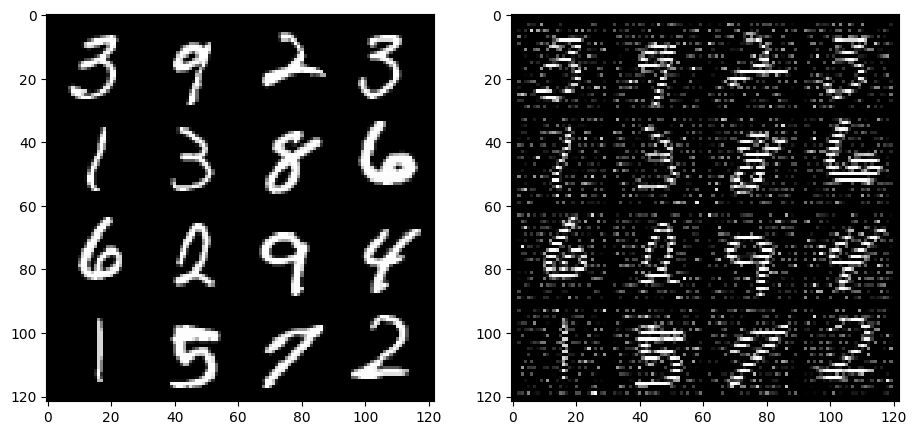

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

%matplotlib inline

# figure size in inches optional
rcParams['figure.figsize'] = 11, 8

# read images
img_A = mpimg.imread('./ebm/groundtruth.png')
img_B = mpimg.imread('./ebm/corrupted.png')

# display images
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img_A)
ax[1].imshow(img_B)

### Submission

You need to submit your code (this notebook), your trained model (named `./ebm/ebmbest.pth`), and your report:

+ **Code**

Remember to run all the cells before submission. Remain your tuned hyperparameters unchanged.

+ **Model**

In this notebook, we select the best model according to the MSE of inpainting. You can also manually test your models and select the best one. **Please do not submit any other checkpoints except for `./ebm/ebmbest.pth`!**

+ **Report**

Please include inpainting examples and the inpainting MSE on validation set in your
report. Note that you only need to write a single report for this coding project.

### Grading

Your implementation will be graded based on **the mean squared error
of inpainting**.

### Tips

+ Training with naive contrastive-divergence algorithm will make your model diverge quickly (think about why). Therefore, you need to add a L2 regularization term $\alpha(E_\theta(x+)^2 + E_\theta(x-)^2)$ to stabilize training.

+ Keep track of the generated samples during training to get a sense of how well your model is evolving.

+ You can take a look at the paper [Implicit Generation and Generalization in Energy Based Models](https://arxiv.org/pdf/1903.08689.pdf) to learn more about useful tricks to get your model working.

+ Make sure your code runs fine with the evaluation cell in this notebook.

## Set Up Code

If you use Colab in this coding project, please uncomment the code, fill the `GOOGLE_DRIVE_PATH_AFTER_MYDRIVE` and run the following cells to mount your Google drive. Then, the notebook can find the required file (i.e., utils.py). If you run the notebook locally, you can skip the following cells.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# import sys
# sys.path.append(GOOGLE_DRIVE_PATH)

In [5]:
from utils import hello
hello()

Good luck!


Finally, please run the following cell to import some base classes for implementation (no matter whether you use colab).

In [ ]:
from collections import deque
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from tqdm.autonotebook import tqdm

import numpy as np
import os
import time
import torch
import torch.nn as nn
import torchvision
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

from utils import save_model, load_model, corruption, train_set, val_set

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

os.makedirs('./ebm', exist_ok=True)


/tmp/ipykernel_1190952/1686533526.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## MLP Model

We have provided an example MLP implementation. Feel free to modify the following cell the implement your own model.

**Note that your model should be an MLP!**

In [7]:
class MlpBackbone(nn.Module):
    def __init__(self, input_shape, hidden_size, activation=nn.functional.silu):
        super(MlpBackbone, self).__init__()
        self.input_shape = input_shape  # (C, H, W)
        self.hidden_size = hidden_size
        
        # Enhanced architecture with spectral normalization and skip connections
        self.fc1 = nn.utils.spectral_norm(nn.Linear(np.prod(self.input_shape), self.hidden_size))
        self.fc2 = nn.utils.spectral_norm(nn.Linear(self.hidden_size, self.hidden_size))
        self.fc3 = nn.utils.spectral_norm(nn.Linear(self.hidden_size, self.hidden_size))
        self.fc4 = nn.utils.spectral_norm(nn.Linear(self.hidden_size, 1))
        
        # Skip connection layers
        self.skip1 = nn.utils.spectral_norm(nn.Linear(np.prod(self.input_shape), self.hidden_size))
        self.skip2 = nn.utils.spectral_norm(nn.Linear(self.hidden_size, self.hidden_size))
        
        # Layer normalization for stability
        self.ln1 = nn.LayerNorm(self.hidden_size)
        self.ln2 = nn.LayerNorm(self.hidden_size)
        self.ln3 = nn.LayerNorm(self.hidden_size)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.1)
        
        self.activation = activation

    def forward(self, x):
        # Flatten input
        x_flat = torch.flatten(x, start_dim=1)
        
        # First layer with skip connection
        h1 = self.activation(self.ln1(self.fc1(x_flat)))
        h1 = h1 + self.skip1(x_flat)  # Skip connection from input
        h1 = self.dropout(h1)
        
        # Second layer with skip connection
        h2 = self.activation(self.ln2(self.fc2(h1)))
        h2 = h2 + self.skip2(h1)  # Skip connection from previous layer
        h2 = self.dropout(h2)
        
        # Third layer
        h3 = self.activation(self.ln3(self.fc3(h2)))
        h3 = self.dropout(h3)
        
        # Final output layer
        out = self.fc4(h3)
        
        return out


## Sampling

Implement Langevin dynamics in the following cell. Pay attention to the gradients of both your energy model and input.

In [8]:
def langevin_step(energy_model, x, step_lr, eps, max_grad_norm):
    """
    Perform one step of Langevin dynamics sampling.

    Args:
        energy_model (nn.Module): The energy-based model used for sampling.
        x (torch.Tensor): The input tensor to update via Langevin dynamics.
        step_lr (float): The learning rate of the optimizer used to update the input.
        eps (float): The step size of the Langevin dynamics update.
        max_grad_norm (float or None): The maximum norm of the gradient for gradient clipping.

    Returns:
        torch.Tensor: The updated input tensor after one step of Langevin dynamics.
    """
    ##############################################################################
    #                  TODO: You need to complete the code here                  #
    ##############################################################################
    # YOUR CODE HERE
    y = x.detach().requires_grad_()
    if y.grad is not None:
        y.grad.zero_()
    energy_model2 = energy_model.__class__(input_shape=energy_model.input_shape, hidden_size=energy_model.hidden_size, activation=energy_model.activation).to(device)
    energy_model2.load_state_dict(energy_model.state_dict())
    energy_model2.zero_grad()
    energy = energy_model2(y).sum()
    energy.backward()
    grad = y.grad
    if torch.norm(grad) > max_grad_norm:
        grad *= (max_grad_norm/torch.norm(grad))
    x = x - step_lr * grad + torch.randn_like(x)*eps
    return x.clamp(0, 1)
    ##############################################################################
    #                              END OF YOUR CODE                              #
    ##############################################################################

## Inpainting

Implement the inpainting procedure. Think about the difference between sampling and inpainting.

In [9]:
# Hyperparams
N_SAMPLE_STEPS = 100
L_STEP_NORM = 0.01
STEP_LR = 1000

In [10]:
def inpainting(energy_model, x, mask, n_steps, step_lr, max_grad_norm):
    """
    Inpainting function that completes an image given a masked input using Langevin dynamics.

    Args:
        energy_model (nn.Module): The energy-based model used to generate the image.
        x (torch.Tensor): The input tensor, a masked image that needs to be completed.
        mask (torch.Tensor): The mask tensor, with the same shape as x, where 1 indicates the corresponding
                             pixel is visible and 0 indicates it is missing.
        n_steps (int): The number of steps of Langevin dynamics to run.
        step_lr (float): The step size of Langevin dynamics.
        max_grad_norm (float or None): The maximum gradient norm to be used for gradient clipping. If None, 
                                       no gradient clipping is performed.

    Returns:
        torch.Tensor: The completed image tensor.
    """
    ##############################################################################
    #                  TODO: You need to complete the code here                  #
    ##############################################################################
    # YOUR CODE HERE
    for _ in range(n_steps):
        new_x = langevin_step(energy_model,x,step_lr,0.005,max_grad_norm)
        x = mask * x + (1 - mask) * new_x
        
    return x.clamp(0,1)
    ##############################################################################
    #                              END OF YOUR CODE                              #
    ##############################################################################

In [11]:
def evaluate(energy_model, val_loader, n_sample_steps, step_lr, langevin_grad_norm, device='cuda'):
    """
    Evaluates the energy model on the validation set and returns the corruption MSE,
    recovered MSE, corrupted images, and recovered images for visualization.

    Args:
        energy_model (nn.Module): Trained energy-based model.
        val_loader (torch.utils.data.DataLoader): Validation data loader.
        n_sample_steps (int): Number of Langevin dynamics steps to take when sampling.
        step_lr (float): Learning rate to use during Langevin dynamics.
        langevin_grad_norm (float): Maximum L2 norm of the Langevin dynamics gradient.
        device (str): Device to use (default='cuda').
    """
    mse = corruption_mse = 0
    energy_before_sampling = energy_after_sampling = 0
    n_batches = 0
    energy_model.eval()

    pbar = tqdm(total=len(val_loader.dataset))
    pbar.set_description('Eval')
    for data, _ in val_loader:
        n_batches += data.shape[0]
        data = data.to(device)
        broken_data, mask = corruption(data, type_='ebm')
        energy_before_sampling += energy_model(broken_data).sum().item()
        recovered_img = inpainting(energy_model, broken_data, mask,
                                   n_sample_steps, step_lr, langevin_grad_norm)
        energy_after_sampling += energy_model(recovered_img).sum().item()

        mse += np.mean((data.detach().cpu().numpy().reshape(-1, 28 * 28) - recovered_img.detach().cpu().numpy().reshape(-1, 28 * 28)) ** 2, -1).sum().item()
        corruption_mse += np.mean((data.detach().cpu().numpy().reshape(-1, 28 * 28) - broken_data.detach().cpu().numpy().reshape(-1, 28 * 28)) ** 2, -1).sum().item()

        pbar.update(data.shape[0])
        pbar.set_description('Corruption MSE: {:.6f}, Recovered MSE: {:.6f}, Energy Before Sampling: {:.6f}, Energy After Sampling: {:.6f}'.format(
            corruption_mse / n_batches, mse / n_batches, energy_before_sampling / n_batches, energy_after_sampling / n_batches))

    pbar.close()
    return (corruption_mse / n_batches, mse / n_batches, data[:100].detach().cpu(), broken_data[:100].detach().cpu(), recovered_img[:100].detach().cpu())

## Training
Fill the missing parts in the `train` function. There are some comments implying what to do in the corresponding blocks.

In [ ]:
import random
def train(n_epochs, energy_model, train_loader, val_loader, optimizer, n_sample_steps, step_lr, langevin_eps, langevin_grad_norm, l2_alpha,
          device='cuda', buffer_maxsize=int(1e4), replay_ratio=0.95, save_interval=1):
    energy_model.to(device)
    replay_buffer = torch.zeros(buffer_maxsize, 1, 28, 28)
    buffer_size = buffer_ptr = 0
    best_mse = np.inf
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=n_epochs, eta_min=1e-5)
    for epoch in range(n_epochs):
        train_loss = energy_before = energy_plus = energy_minus = n_batches = 0
        pbar = tqdm(total=len(train_loader.dataset))
        pbar.set_description('Train')
        for i, (x_plus, _) in enumerate(train_loader):
            n_batches += x_plus.shape[0]
            bs = x_plus.shape[0]

            # init negative samples
            if buffer_size == 0:
                x_minus = torch.rand_like(x_plus)
            else:
                ##############################################################################
                #                  TODO: You need to complete the code here                  #
                ##############################################################################
                # YOUR CODE HERE
                if random.random() < replay_ratio:
                    indices = (torch.rand([len(x_plus)]) * buffer_size).to(torch.int64)
                    x_minus = replay_buffer[indices[:]]
                else:
                    x_minus = torch.rand_like(x_plus)
                # raise NotImplementedError()
                ##############################################################################
                #                              END OF YOUR CODE                              #
                ##############################################################################
            x_minus = x_minus.to(device)

            energy_before += energy_model(x_minus).sum().item()

            # sample negative samples
            ##############################################################################
            #                  TODO: You need to complete the code here                  #
            ##############################################################################
            # YOUR CODE HERE
            # raise NotImplementedError()
            x_minus = inpainting(energy_model,x_minus,torch.zeros_like(x_minus),n_sample_steps,step_lr,langevin_grad_norm).detach()
            ##############################################################################
            #                              END OF YOUR CODE                              #
            ##############################################################################

            # extend buffer
            if buffer_ptr + bs <= buffer_maxsize:
                replay_buffer[buffer_ptr: buffer_ptr +
                              bs] = ((x_minus * 255).to(torch.uint8).float() / 255).cpu()
            else:
                x_minus_ = (
                    (x_minus * 255).to(torch.uint8).float() / 255).cpu()
                replay_buffer[buffer_ptr:] = x_minus_[
                    :buffer_maxsize - buffer_ptr]
                remaining = bs - (buffer_maxsize - buffer_ptr)
                replay_buffer[:remaining] = x_minus_[
                    buffer_maxsize - buffer_ptr:]
            buffer_ptr = (buffer_ptr + bs) % buffer_maxsize
            buffer_size = min(buffer_maxsize, buffer_size + bs)

            # compute loss
            energy_model.train()
            x_plus = x_plus.to(device)
            x_minus = x_minus.to(device)
            e_plus = energy_model(x_plus)
            e_minus = energy_model(x_minus)
            ##############################################################################
            #                  TODO: You need to complete the code here                  #
            ##############################################################################
            # YOUR CODE HERE
            optimizer.zero_grad()
            
            # Main contrastive divergence loss
            cd_loss = (e_plus - e_minus).mean()
            
            # L2 regularization
            reg_loss = l2_alpha * (e_plus.pow(2).mean() + e_minus.pow(2).mean())
            
            # Gradient penalty for stability
            alpha = torch.rand(x_plus.size(0), 1, 1, 1, device=device)
            interpolates = (alpha * x_plus + ((1 - alpha) * x_minus)).requires_grad_(True)
            d_interpolates = energy_model(interpolates)
            gradients = torch.autograd.grad(
                outputs=d_interpolates,
                inputs=interpolates,
                grad_outputs=torch.ones_like(d_interpolates),
                create_graph=True,
                retain_graph=True,
                only_inputs=True,
            )[0]
            gradients = gradients.view(gradients.size(0), -1)
            gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
            
            # Combined loss
            loss = cd_loss + reg_loss + 10 * gradient_penalty
            
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(energy_model.parameters(), 1.0)
            
            optimizer.step()
            ##############################################################################
            #                              END OF YOUR CODE                              #
            ##############################################################################

            train_loss += loss.sum().item()
            energy_plus += e_plus.sum().item()
            energy_minus += e_minus.sum().item()

            pbar.update(x_plus.size(0))
            pbar.set_description("Train Epoch {}, Train Loss: {:.6f}, ".format(epoch + 1, train_loss / n_batches) +
                                 "Energy Before Sampling: {:.6f}, ".format(energy_before / n_batches) +
                                 "Energy After Sampling: {:.6f}, ".format(energy_minus / n_batches) +
                                 "Energy of Ground Truth: {:.6f}".format(energy_plus / n_batches) + 
                                 "Learning Rate: {:.6f}".format(optimizer.param_groups[0]['lr']))
        pbar.close()
        scheduler.step()
        if (epoch + 1) % save_interval == 0:
            os.makedirs(f'./ebm/{epoch + 1}', exist_ok=True)
            energy_model.eval()
            save_model(f'./ebm/{epoch + 1}/ebm.pth',
                       energy_model, optimizer, replay_buffer)

            # evaluate inpaiting
            # feel free to change the inpainting parameters!
            c_mse, r_mse, original, broken, recovered = evaluate(energy_model, val_loader,
                                                                N_SAMPLE_STEPS, STEP_LR, L_STEP_NORM, device=device)
            torchvision.utils.save_image(
                original, f"./ebm/{epoch + 1}/groundtruth.png", nrow=10)
            torchvision.utils.save_image(
                broken, f"./ebm/{epoch + 1}/corrupted.png", nrow=10)
            torchvision.utils.save_image(
                recovered, f"./ebm/{epoch + 1}/recovered.png", nrow=10)
            if r_mse < best_mse:
                print(f'Current best MSE: {best_mse} -> {r_mse}')
                best_mse = r_mse
                save_model('./ebm/ebmbest.pth', energy_model)

In [13]:
model = MlpBackbone((1, 28, 28), 2048).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.0, 0.999))

train_loader = DataLoader(train_set, 2048, shuffle=True, drop_last=False, pin_memory=True)
val_loader = DataLoader(val_set, 1000, shuffle=True, drop_last=False, pin_memory=True)

Now you can start your training. Please keep in mind that this cell may **NOT** be run when we evaluate your assignment!

In [14]:
# # feel free the change training hyper-parameters!
# # train(20, model, train_loader, val_loader, opt imizer, 60, 1, 0.005, 0.03, 0.1)
# # train(20, model, train_loader, val_loader, opt imizer, 60, 1, 0.005, 0.03, 0.1)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.0, 0.999))
# train(30, model, train_loader, val_loader, optimizer,n_sample_steps=N_SAMPLE_STEPS,step_lr=STEP_LR,langevin_grad_norm=L_STEP_NORM,l2_alpha=0.3,langevin_eps=None)

## Evaluation

Make sure you can run the following evaluation cell.

In [ ]:
# feel free to change evaluation parameters!
# inpainting parameters are not necessarily the same as sampling parameters
n_sample_steps = N_SAMPLE_STEPS
step_lr = STEP_LR
langevin_grad_norm = L_STEP_NORM
state_dict = load_model('./ebm/ebmbest.pth')[0]
model = MlpBackbone((1, 28, 28), 2048).to(device)
model.load_state_dict(state_dict)
model.eval()

/scorpio/home/liuhanzuo/DL2025/CodingProject3/utils.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(load_path)


MlpBackbone(
  (fc1): Linear(in_features=784, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=2048, bias=True)
  (fc3): Linear(in_features=2048, out_features=2048, bias=True)
  (fc4): Linear(in_features=2048, out_features=1, bias=True)
  (skip1): Linear(in_features=784, out_features=2048, bias=True)
  (skip2): Linear(in_features=2048, out_features=2048, bias=True)
  (ln1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
  (ln2): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
  (ln3): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
corruption_mse, mse, data, broken, revovered = evaluate(model, val_loader, n_sample_steps, step_lr, langevin_grad_norm, device=device)
print(f'Corruption MSE: {corruption_mse}')
print(f'Recovered MSE: {mse}')
torchvision.utils.save_image(data,'./ebm/data.png',nrow=10)
torchvision.utils.save_image(broken,'./ebm/data_corrupted.png',nrow=10)
torchvision.utils.save_image(revovered,'./ebm/data_recovered.png',nrow=10)

Eval:   0%|          | 0/10000 [00:00<?, ?it/s]

Corruption MSE: 0.063346, Recovered MSE: 0.031415, Energy Before Sampling: 1.276694, Energy After Sampling: 0.016626: 100%|██████████| 10000/10000 [02:55<00:00, 56.99it/s]

Corruption MSE: 0.06334577293395996
Recovered MSE: 0.031414740180969236
